Benjamin Nguyen

Computer Vision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage 
from skimage import io, color, filters, util, data, transform, feature
from skimage.registration import optical_flow_ilk



## **Exercise 1**

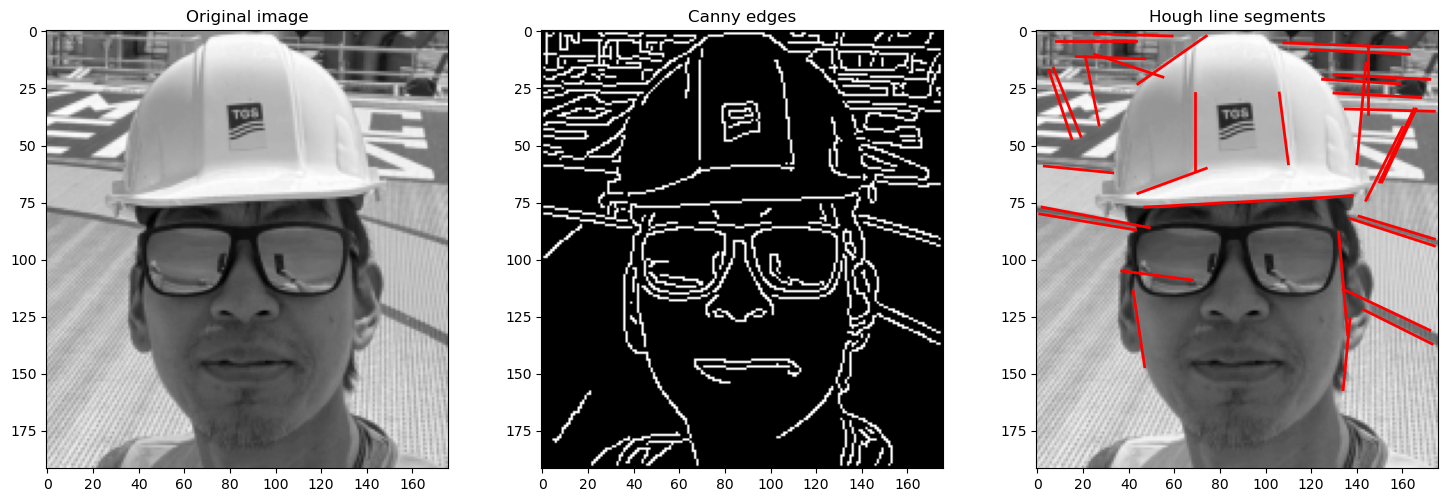

In [2]:
# Load and preprocess image
img_color = io.imread('newpics/me.png')
img_gray = util.img_as_float32(color.rgb2gray(img_color))
img_gray = transform.rescale(img_gray, 1/5, channel_axis=None)

# Compute edges
edges = feature.canny(img_gray, sigma=1.0)

# Compute probabilistic Hough transform
lines = transform.probabilistic_hough_line(
    edges, threshold=10, line_length=30, line_gap=3
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax0, ax1, ax2 = axes

# Original image
ax0.imshow(transform.rescale(img_color, 1/5), cmap='gray')
ax0.set_title("Original image")
# ax0.axis("off")

# Canny edges
ax1.imshow(edges, cmap='gray')
ax1.set_title("Canny edges")

# Hough line segments
ax2.imshow(img_gray, cmap='gray')
for (p0, p1) in lines:
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]), 'r-', linewidth=2)
ax2.set_title("Hough line segments")

plt.tight_layout()
plt.show()


## **Exercise 2**

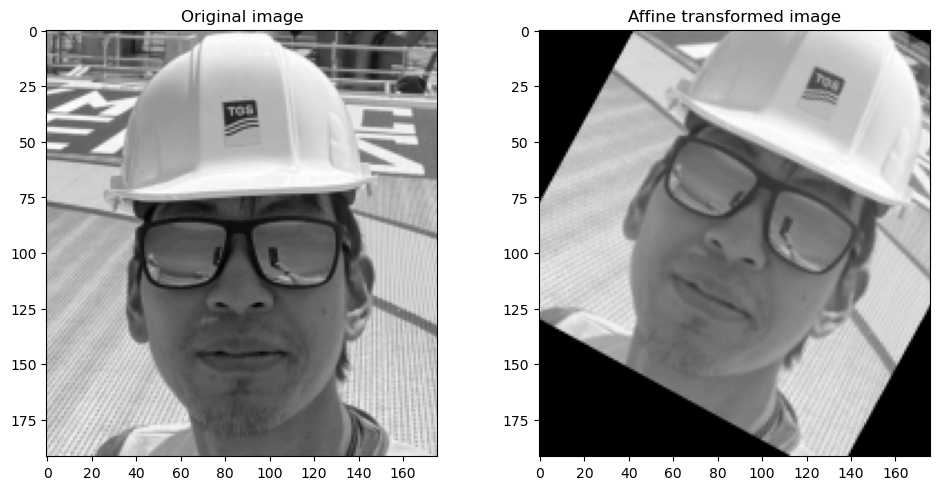

In [3]:
# Apply affine transformation
tform = transform.AffineTransform(scale=(1., 1.), rotation=0.5, translation=(70, -50))
img2 = transform.warp(img_gray, tform.inverse, output_shape=img_gray.shape)


# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes

ax0.imshow(img_gray, cmap='gray')
ax0.set_title("Original image")
ax1.imshow(img2, cmap='gray')
ax1.set_title("Affine transformed image")

plt.tight_layout()
plt.show()




Original image keypoints: 232
Transformed image keypoints: 175


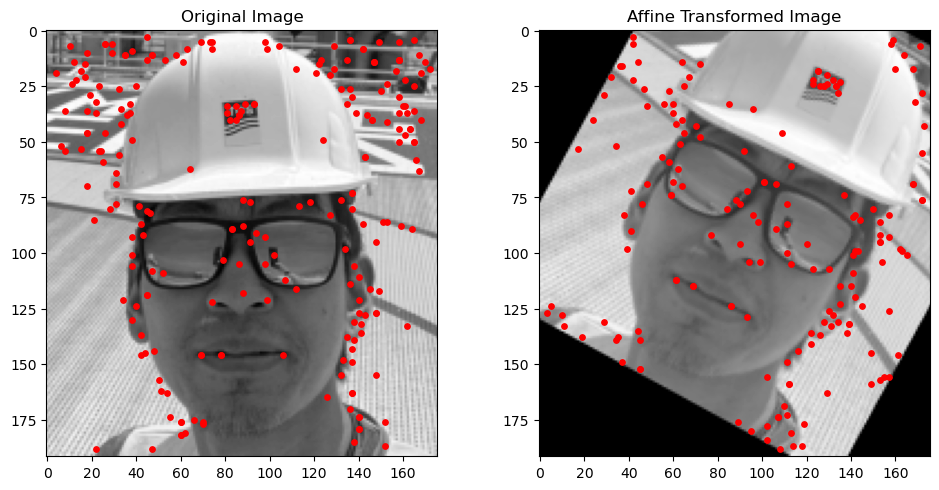

In [4]:
sift1 = feature.SIFT()
sift1.detect_and_extract(img_gray)
kp1, desc1 = sift1.keypoints, sift1.descriptors

sift2 = feature.SIFT()
sift2.detect_and_extract(img2)
kp2, desc2 = sift2.keypoints, sift2.descriptors

print(f"Original image keypoints: {len(kp1)}")
print(f"Transformed image keypoints: {len(kp2)}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes

ax0.imshow(img_gray, cmap='gray')
ax0.scatter(kp1[:, 1], kp1[:, 0], facecolors='red', edgecolors='r',  s=15)
ax0.set_title(f"Original Image")

ax1.imshow(img2, cmap='gray')
ax1.scatter(kp2[:, 1], kp2[:, 0], facecolors='red', edgecolors='r', s=15)
ax1.set_title(f"Affine Transformed Image")

plt.tight_layout()
plt.show()

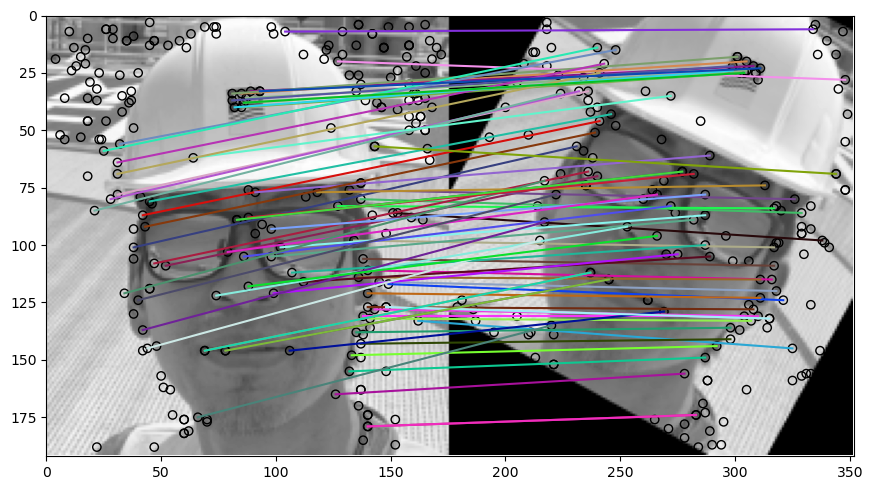

In [5]:
matches = feature.match_descriptors(
    desc1, desc2,
    metric='euclidean',
    max_ratio=0.7,      
    cross_check=True  
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
feature.plot_matches(ax, img_gray, img2, kp1, kp2, matches)
plt.tight_layout()
plt.show()

## **Exercise 3**

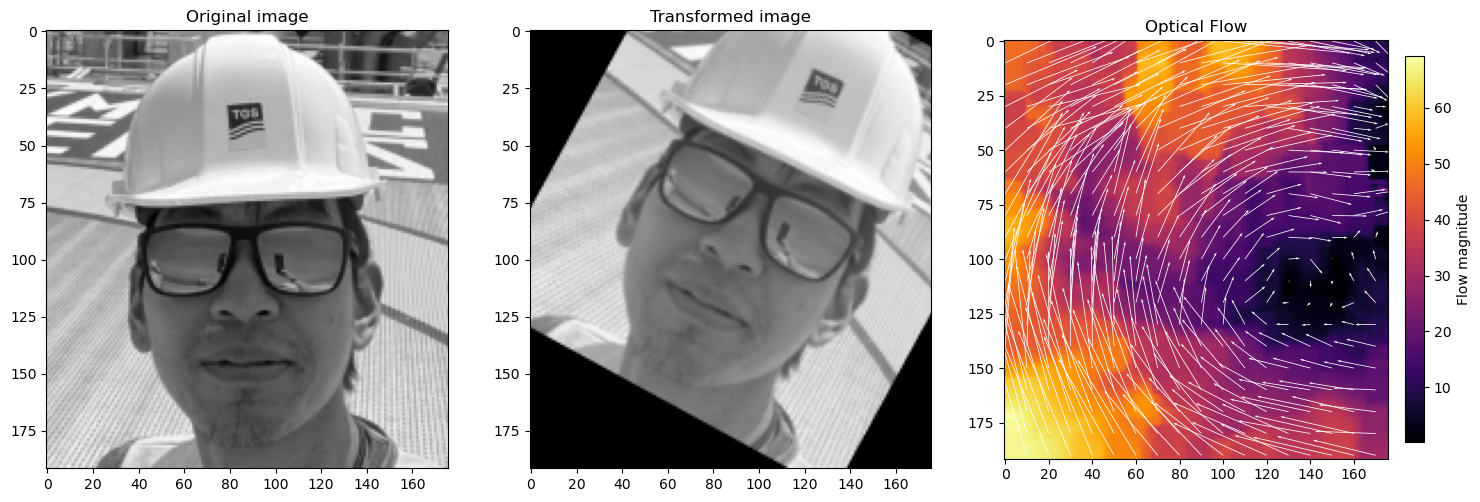

In [6]:
v, u = optical_flow_ilk(img_gray, img2, radius=7, num_warp=5)

# Flow magnitude
magnitude = np.sqrt(u**2 + v**2)

nr, nc = img_gray.shape
r, c = np.mgrid[0:nr, 0:nc]
step = 10  # quiver step size

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax0, ax1, ax2 = axes

ax0.imshow(img_gray, cmap='gray')
ax0.set_title("Original image")

ax1.imshow(img2, cmap='gray')
ax1.set_title("Transformed image")

flow_plot = ax2.imshow(magnitude, cmap='inferno')
ax2.quiver(
    c[::step, ::step], r[::step, ::step],
    u[::step, ::step], v[::step, ::step],
    angles='xy', scale_units='xy', scale=1, width=0.002, color='white'
)
ax2.set_title("Optical Flow")

# Add colorbar for magnitude
fig.colorbar(flow_plot, ax=ax2, fraction=0.046, pad=0.04, label='Flow magnitude')

plt.tight_layout()
plt.show()

The optical flow is not correct for all pixels, but most of the pixel are correct.

There are pixcels for which the optical flow is wrong, because:

- Regions leavingthe frame due to translation/rotation, so there is no valid matching pixels.

- Flat or textureless areas because they can have no gradient.
 
- Image borders / black corners after rotation, so pixels have no correspondence